Добрый день. Я делал проект с большим перерывом, был в отпуске, возможно где то может показаться, что все запутано, но это не так :)

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных

*Признаки*

- `DateCrawled`  дата скачивания анкеты из базы
    
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя


*Целевой признак*

- `Price` — цена (евро)



Установка библиотек!

In [122]:
#pip install --upgrade pip

In [123]:
#pip install lightgbm

In [124]:
#pip install catboost

In [125]:
# import labraris
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import  make_scorer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

import warnings
warnings.simplefilter('ignore')

## Обзор данных

In [126]:
try:
    data = pd.read_csv('autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [127]:
data.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [128]:
cat_fiatures_list = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']

In [129]:
data.shape

(354369, 16)

Названия колонк не соответствуют общепринятому стилю, необходимо ререименовать.

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Необходимо привести типы данных в соответствии с хранимыми данными.

In [131]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [132]:
data.isna().mean().sort_values(ascending=False)

NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Kilometer            0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Пропуски по большей части в котегориальных данных.

In [133]:
data.duplicated().sum()

4

Нашлось 4 дубликата 

In [134]:
for i in cat_fiatures_list:
    print(i)
    print(data[i].unique())

VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Gearbox
['manual' 'auto' nan]
Model
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore'

В значениях обектовых признаков есть значения "other", при заполнении пропусков пропущенные значения будем обозночать 'other'

### Вывод

- Нужно привести названия колонко к стандартному стилю написания
- Необходимо привести типы данных в соответствии с хранимыми данными.
- Заплнить пропущенные значения
- Удалить дубликаты.
- П


## Предобрабодтка данных

In [135]:
df = data.copy()

### Измененние названия столбцов

In [136]:
# Изменнение названия столбцов
df.columns = df.columns.str.lower()
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [137]:
correct_column_dict = {'datecrawled': 'date_carwled',
                       'vehicletype': 'vhicle_type',
                       'registrationyear': 'registration_year',
                       'registrationmonth': 'registration_month',
                       'fueltype': 'fuel_type',
                       'notrepaired': 'not_repaired',
                       'datecreated': 'date_created', 
                       'numberofpictures': 'number_of_pictures',
                       'postalcode': 'postal_code',
                       'lastseen': 'last_seen'}

In [138]:
df = df.rename(columns=correct_column_dict)


In [139]:
df.columns

Index(['date_carwled', 'price', 'vhicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Изменение типов данных

In [140]:
df.head()

,date_carwled,price,vhicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [141]:
pd.to_datetime(df['date_carwled'])

0        2016-03-24 11:52:17
1        2016-03-24 10:58:45
2        2016-03-14 12:52:21
3        2016-03-17 16:54:04
4        2016-03-31 17:25:20
                 ...        
354364   2016-03-21 09:50:58
354365   2016-03-14 17:48:27
354366   2016-03-05 19:56:21
354367   2016-03-19 18:57:12
354368   2016-03-20 19:41:08
Name: date_carwled, Length: 354369, dtype: datetime64[ns]

In [142]:
df['date_carwled'] = pd.to_datetime(df['date_carwled'])
df['date_created'] = pd.to_datetime(df['date_created'])
df['last_seen'] = pd.to_datetime(df['last_seen'])

### Удаление дубликатов.

In [143]:
df.duplicated().sum()

4

In [144]:
df.drop_duplicates(inplace=True)

Явне дубликаты удалены, но я заметил что в некоторых записях дата последней активности пользователя позже даты выгрузки из базы. Что может свидетельстовать о том что пользователь заходил и что то правил в объявлении, Посмотрм сколько дубликатов если исклюсить эти два столбца.

In [145]:
df.iloc[:, 1:-1].duplicated().sum()

10190

Чуть больше 10 тысяч. Удалим эти записи.

In [146]:
df = df.drop_duplicates(subset=df.columns[1:-1])

### Замена пропущенных значений

Для начала рассмотрим пропущенные значения в чисовых данных 

In [147]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,344175.000000,344175.000000,344175.000000,344175.000000,344175.000000,344175.0,344175.000000
mean,4395.893249,2004.223578,109.904886,128256.744389,5.704525,0.0,50539.510069
std,4506.888598,90.906705,191.468515,37907.597348,3.729554,0.0,25812.880706
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1000.000000,1999.000000,68.000000,125000.000000,3.000000,0.0,30163.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49393.000000
75%,6300.000000,2008.000000,141.000000,150000.000000,9.000000,0.0,71155.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Есть записи в которых присутствуют неявные пропуски, цена не может быть 0, только если отдать даром, но нас такой вариант не интересует, основная масса клиентов желает узнать реальную рыночную стоимость своего автомобиля. Поэтому удалим эти записи

In [148]:
df = df.query("price > 0 and power > 0")


In [149]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,297916.000000,297916.000000,297916.000000,297916.000000,297916.000000,297916.0,297916.000000
mean,4790.397518,2003.493038,124.104654,128475.174210,5.954155,0.0,51192.743357
std,4580.499936,32.573404,196.682084,36743.559677,3.603782,0.0,25794.036664
min,1.000000,1000.000000,1.000000,5000.000000,0.000000,0.0,1067.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30900.000000
50%,3050.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,50170.000000
75%,6900.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,72108.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


###

Проверим данные на аномалии. Проверять буду только те признаки которые в дальнейшем планирую использовать для обучения модели

<AxesSubplot:ylabel='price'>

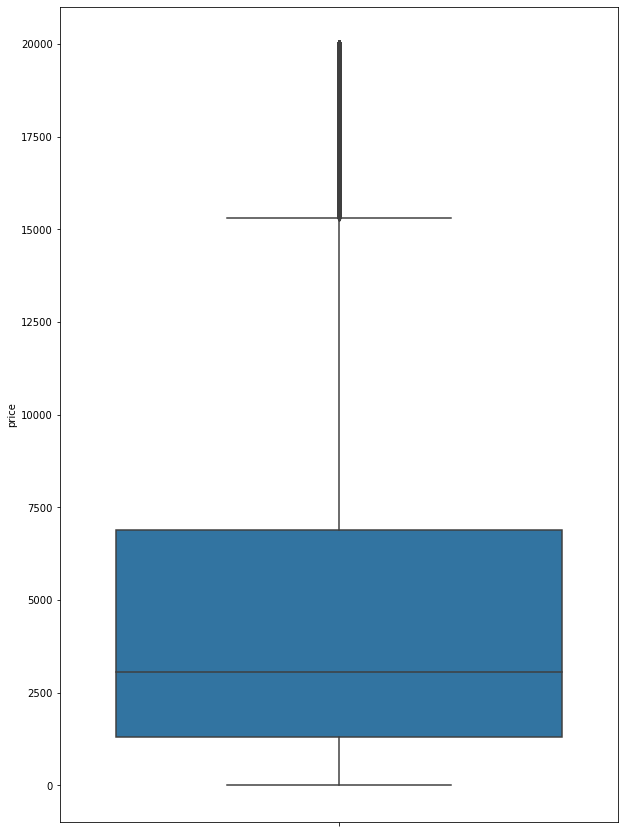

In [150]:
plt.figure(figsize=(10,15))
sns.boxplot(y=df['price'])

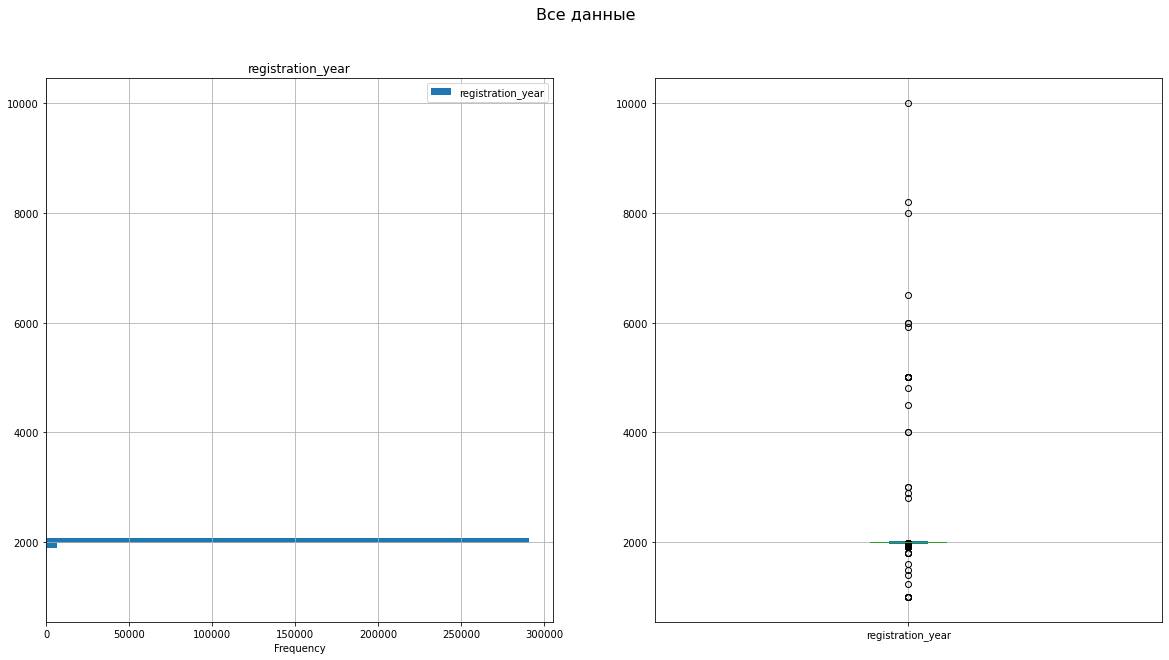

In [151]:
    plt.suptitle('Все данные', fontsize=16)
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    df.plot(
        kind='hist',
        y='registration_year',
        ax=ax1,
        bins=100,
        orientation=u'horizontal',
        label='registration_year',
        figsize=(20,10),
        title='registration_year',
        grid=True,
        legend=True)

    
    df.plot(
        kind='box',
        ax=ax2,
        y='registration_year',
        grid=True)
    plt.show()

С годом регистрации большые проблемы. Есть аномальные значения. Посмотрим на последнью дату создания анкеты

In [152]:
df['date_created'].max()

Timestamp('2016-04-07 00:00:00')

Последняя анкета создана в 2016 году значит, все записи в которых год регистрации больше 2016 будем считать аномальными значениями и удалим их, так же уберем вбросы с нижней границы, подбирал в ручную без использования полуторного межквартельного размаха.

<AxesSubplot:>

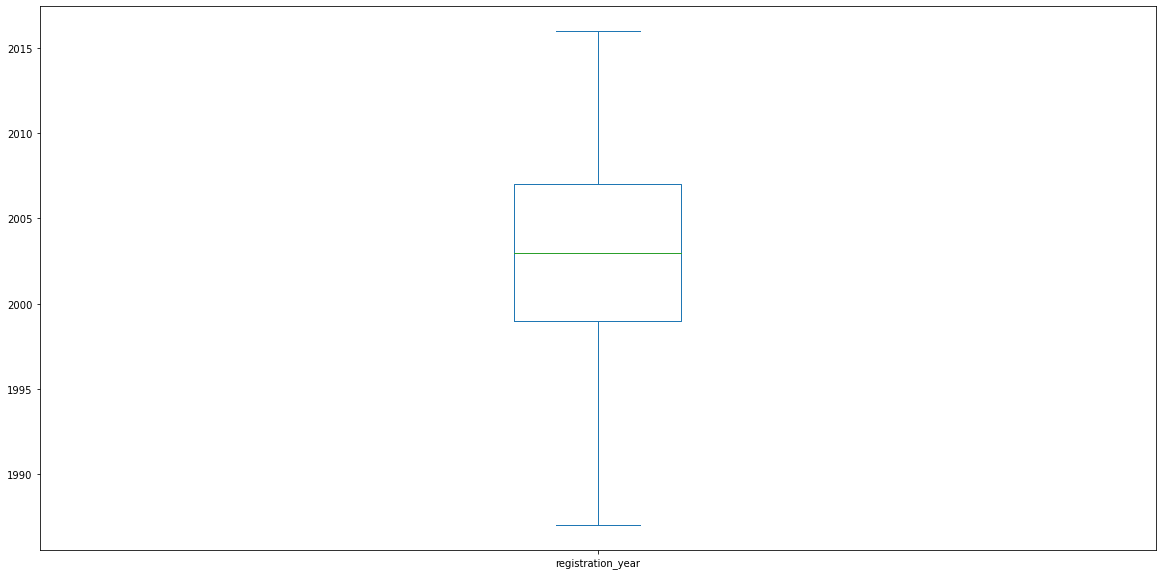

In [153]:
df[(df['registration_year'] <= 2016) & (df['registration_year'] >= 1987) ].plot(kind='box', y='registration_year', figsize=(20,10))

Price - длинный правый хвост
Год регистрации совсем не понято что происходит
Мощьность очень странные значения

In [154]:
df = df[(df['registration_year'] <= 2016) & (df['registration_year'] >= 1987) ]

<AxesSubplot:ylabel='power'>

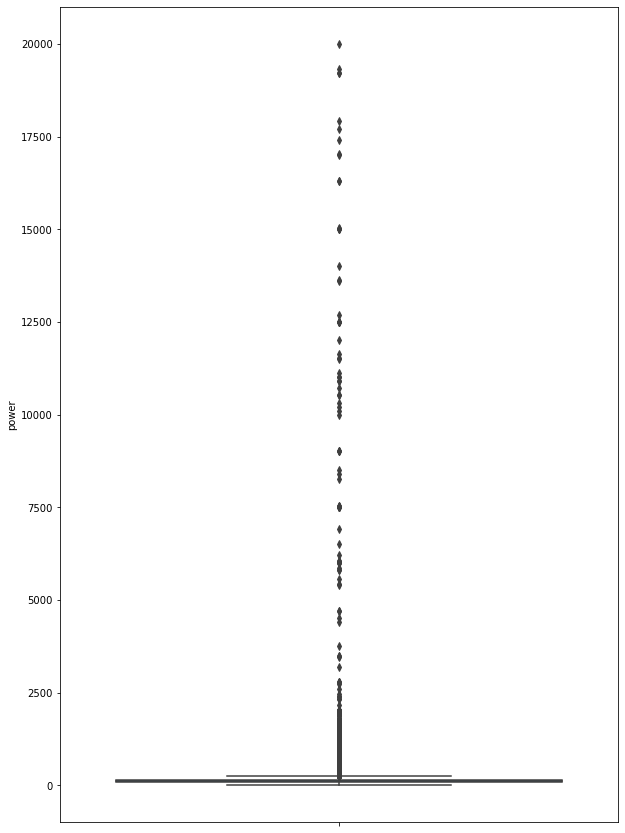

In [155]:
plt.figure(figsize=(10,15))
sns.boxplot(y=df['power'])

Уберем вборосы использую полуторный межквартельный размах

In [156]:
def quantile_range(columns):
    # Первая квантиль
    Q1 = df[columns].quantile(0.25)
    # Третья квантиль
    Q3 = df[columns].quantile(0.75)
    # Межквантильное расстояние
    IQR = Q3 - Q1
    
    min_range = Q1 - 1.5 * IQR
    max_range = Q3 + 1.5 * IQR
    
    if min_range < 0:
        min_range = 0
        
    return min_range, max_range

In [157]:
min_range, max_range = quantile_range('power')
df = df.loc[(df['power'] >= min_range) & (df['power'] <= max_range)]

<AxesSubplot:ylabel='power'>

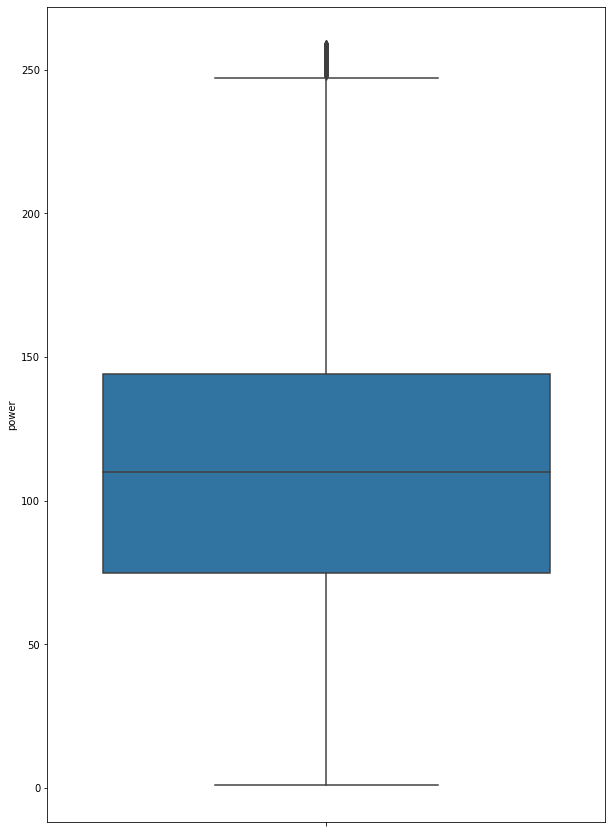

In [158]:
plt.figure(figsize=(10,15))
sns.boxplot(y=df['power'])

Данные отчищены от вбросов.

### Данные типа Object

In [159]:
# Удлим записи где есть 4 пропущенных признака 
df = df.dropna(axis=0,thresh=12)

Для остальных данных заменим пропуски на 'other'

In [160]:
df = df.fillna('other')

In [161]:
df.isna().sum()

date_carwled          0
price                 0
vhicle_type           0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

### Вывод

Данные отчищены от пропусков и аномальных значений 

## Подготовка данных

Что бы подготовить данные для обучения  целевой признак 

In [162]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,276994.000000,276994.000000,276994.000000,276994.000000,276994.000000,276994.0,276994.000000
mean,4672.246937,2003.188690,116.727034,128623.905211,5.994245,0.0,51262.507596
std,4476.535660,5.694255,45.848473,36485.242166,3.587914,0.0,25789.248070
min,1.000000,1987.000000,1.000000,5000.000000,0.000000,0.0,1067.000000
25%,1299.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30926.000000
50%,3000.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,50226.000000
75%,6750.000000,2007.000000,144.000000,150000.000000,9.000000,0.0,72124.000000
max,20000.000000,2016.000000,259.000000,150000.000000,12.000000,0.0,99998.000000


Уберем из данных признаки которые не несут полезнай нагрузки на конечный продукт.

In [163]:
df.head(1)

,date_carwled,price,vhicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50


In [164]:
df.drop(['date_carwled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis = 1, inplace = True)


Перед обучением модели посмотрим как коррелируют между собой признаки 

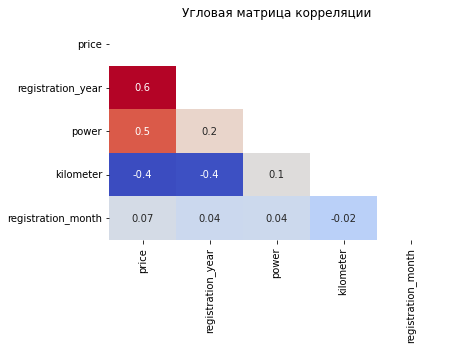

In [165]:
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, mask=matrix,
                fmt='.1g', cmap='coolwarm', cbar=False)

plt.title('Угловая матрица корреляции')
plt.show()

Наибольшая зависимость наблюдается между годом регистрации и ценой.

### Подготовка признаков 

In [166]:
# Выделим целевую пересенную и признаки
target = df['price']
features = df.drop('price', axis=1)

In [167]:
df.head()

,price,vhicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


In [168]:
# Функция в зависимости от передаваемого типа кодирования категориальных данных, возвращает преобразованные данные,
# и разделяет тернировочные и тестовые данные
def split_sample(data, method):
    scaler = StandardScaler()
    numeric = ['power', 'kilometer' ]
    categorian_columns = ['vhicle_type', 'registration_year', 'gearbox', 'model', 'fuel_type', 'brand',
                          'not_repaired', 'registration_month']
    features = data.drop('price', axis=1)
    target = data['price']
    if method == 'OHE':
        features = pd.get_dummies(features, drop_first=True)
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=1)
        
    if method == 'OrdinalEncoder':
        ord_enc = OrdinalEncoder()
        ord_enc.fit(features[categorian_columns])
        features[categorian_columns] = ord_enc.transform(features[categorian_columns])

    if method == 'LabelEncoder':
        for col in categorian_columns:
            features[col] = LabelEncoder().fit_transform(features[col])

    if method == 'CategorianFeatures':
        for col in categorian_columns:
            features[col] = features[col].astype("category")
        
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=1)
    scaler.fit(X_train[numeric])
    X_train[numeric] = scaler.transform(X_train[numeric])
    X_test[numeric] = scaler.transform(X_test[numeric])
    return X_train, X_test, y_train, y_test



### Вывод

Для подготовки данных была написана функция котороая в последуюшем будет вызываться в функции get_best_model

## Обучение моделей

In [169]:
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

In [170]:
score_rmse = make_scorer(rmse)

In [171]:
#Большой блок из двух функиц. Первая функция нужна для составления итоговой таблице.
# Во второй функии идет разделение данных на выборки, препроцессинг данных, подбор гиперпараметров модели, обучение.
# Не много нагруженная получилась но мне так удабней.

best_models = dict(pre_processing = [], estimator = [],
                   best_parameters= [], score = [],
                   RMSE_test = [], fit_time = [],
                   pred_time = []   )
score_list = {}
def _best_parameters(preprocessing, estimator,best_parameters, score, test_score, fit_time, pred_time):
    value = "Best parameters: "
    best_models['pre_processing'].append(preprocessing)
    best_models['estimator'].append(estimator)
    best_models['best_parameters'].append(best_parameters)
    best_models['score'].append(score)
    best_models['RMSE_test'].append(test_score)
    best_models['fit_time'].append(fit_time)
    best_models['pred_time'].append(pred_time)

def get_best_model(estimator, hyperparameters, preprocessing):
    cv = 3
    X_train, X_test, y_train, y_test = split_sample(df, preprocessing)
    grid_search = GridSearchCV(estimator=estimator,
                               param_grid=hyperparameters,
                               n_jobs=-1,
                               cv=cv,
                               scoring='neg_mean_squared_error', 
                               )
    if preprocessing == 'CategorianFeatures':
        cat_features = list(X_train.select_dtypes(include='category').columns)
        start_time_fit = datetime.now()
        best_model = grid_search.fit(X_train, y_train, cat_features = cat_features, verbose=30)
        total_fit_time = datetime.now() - start_time_fit
    else:
        start_time_fit = datetime.now()
        total_fit_time = datetime.now() - start_time_fit
        best_model = grid_search.fit(X_train, y_train)
        total_fit_time = datetime.now() - start_time_fit
        
    best_parameters = best_model.best_estimator_.get_params()
    best_score = (-best_model.best_score_) ** 0.5
    start_time_pred = datetime.now()
    predict_test = best_model.predict(X_test)
    total_time_pred = datetime.now() - start_time_pred
    best_test_score = rmse(y_test,predict_test )
    _best_parameters(preprocessing ,estimator, best_parameters, best_score,best_test_score,total_fit_time,total_time_pred )
    
    return best_model


### Линейная регресси

In [172]:
%%time
linearegreshion = get_best_model(LinearRegression(), dict(), 'OHE')

Wall time: 18.9 s


### Случайный лес

In [173]:
%%time
randomforest = get_best_model(RandomForestRegressor(random_state=1), 
                              dict(n_estimators=list(range(20, 25, 1)), max_depth=list(range(17, 20, 1))),
                             'OrdinalEncoder')

Wall time: 2min 32s


### LightGBM

In [174]:
%%time
light_gbm = get_best_model(LGBMRegressor(random_state=1), 
                           dict(max_depth=list(range(17,20,1)), n_estimators=list(range(20, 25, 1))),
                           'OHE')

In [175]:
%%time
light_gbm = get_best_model(LGBMRegressor(random_state=1), 
                           dict(max_depth=list(range(17,20,1)), n_estimators=list(range(20, 25, 1))),
                           'OrdinalEncoder')

### CatBoostRegressor

In [176]:
%%time
cat_boost = get_best_model(CatBoostRegressor(random_state=1), 
                           dict(max_depth=list(range(5,15,1)), n_estimators=list(range(20, 25, 1))),
                           'OHE')

Learning rate set to 0.5
0:	learn: 2898.5021458	total: 382ms	remaining: 8.78s
1:	learn: 2164.5072141	total: 764ms	remaining: 8.41s
2:	learn: 1865.3094366	total: 1.15s	remaining: 8.03s
3:	learn: 1737.5313909	total: 1.54s	remaining: 7.71s
4:	learn: 1663.4300066	total: 1.91s	remaining: 7.27s
5:	learn: 1629.2600265	total: 2.27s	remaining: 6.81s
6:	learn: 1609.7146091	total: 2.62s	remaining: 6.37s
7:	learn: 1594.4035512	total: 2.99s	remaining: 5.98s
8:	learn: 1577.6008740	total: 3.35s	remaining: 5.59s
9:	learn: 1566.9713045	total: 3.7s	remaining: 5.19s
10:	learn: 1557.1143561	total: 4.07s	remaining: 4.81s
11:	learn: 1544.8849809	total: 4.44s	remaining: 4.44s
12:	learn: 1538.9309881	total: 4.8s	remaining: 4.07s
13:	learn: 1527.6839160	total: 5.17s	remaining: 3.69s
14:	learn: 1518.3260887	total: 5.54s	remaining: 3.32s
15:	learn: 1512.5482312	total: 5.9s	remaining: 2.95s
16:	learn: 1506.4675624	total: 6.28s	remaining: 2.58s
17:	learn: 1497.4345201	total: 6.66s	remaining: 2.22s
18:	learn: 1486.

In [177]:
%%time
cat_boost = get_best_model(CatBoostRegressor(random_state=1), 
                           dict(max_depth=list(range(12,15,1)), n_estimators=list(range(22, 25, 1))),
                           'CategorianFeatures')

Learning rate set to 0.5
0:	learn: 2961.0354738	total: 589ms	remaining: 13.6s
23:	learn: 1376.0299518	total: 14.3s	remaining: 0us


###

In [179]:
total_table = pd.DataFrame.from_dict(best_models, orient='index').T

,pre_processing,estimator,best_parameters,score,RMSE_test,fit_time,pred_time
0,OHE,LinearRegression(),"{'copy_X': True, 'fit_intercept': True, 'n_job...",2293.287388,2283.78939,0 days 00:00:16.843001,0 days 00:00:00.146447
1,OrdinalEncoder,RandomForestRegressor(random_state=1),"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",1529.468544,1489.946681,0 days 00:02:30.300952,0 days 00:00:00.593178
2,OHE,LGBMRegressor(random_state=1),"{'boosting_type': 'gbdt', 'class_weight': None...",1839.840714,1834.13491,0 days 00:00:44.469022,0 days 00:00:00.323584
3,OrdinalEncoder,LGBMRegressor(random_state=1),"{'boosting_type': 'gbdt', 'class_weight': None...",1863.302354,1854.607006,0 days 00:00:11.138993,0 days 00:00:00.072188
4,OHE,<catboost.core.CatBoostRegressor object at 0x0...,"{'loss_function': 'RMSE', 'max_depth': 14, 'n_...",1539.592932,1524.778939,0 days 00:04:51.801112,0 days 00:00:00.051138
5,CategorianFeatures,<catboost.core.CatBoostRegressor object at 0x0...,"{'loss_function': 'RMSE', 'max_depth': 13, 'n_...",1543.739221,1517.084522,0 days 00:03:14.005006,0 days 00:00:00.076095


## Анализ моделей

In [181]:
total_table

,pre_processing,estimator,best_parameters,score,RMSE_test,fit_time,pred_time
0,OHE,LinearRegression(),"{'copy_X': True, 'fit_intercept': True, 'n_job...",2293.287388,2283.78939,0 days 00:00:16.843001,0 days 00:00:00.146447
1,OrdinalEncoder,RandomForestRegressor(random_state=1),"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",1529.468544,1489.946681,0 days 00:02:30.300952,0 days 00:00:00.593178
2,OHE,LGBMRegressor(random_state=1),"{'boosting_type': 'gbdt', 'class_weight': None...",1839.840714,1834.13491,0 days 00:00:44.469022,0 days 00:00:00.323584
3,OrdinalEncoder,LGBMRegressor(random_state=1),"{'boosting_type': 'gbdt', 'class_weight': None...",1863.302354,1854.607006,0 days 00:00:11.138993,0 days 00:00:00.072188
4,OHE,<catboost.core.CatBoostRegressor object at 0x0...,"{'loss_function': 'RMSE', 'max_depth': 14, 'n_...",1539.592932,1524.778939,0 days 00:04:51.801112,0 days 00:00:00.051138
5,CategorianFeatures,<catboost.core.CatBoostRegressor object at 0x0...,"{'loss_function': 'RMSE', 'max_depth': 13, 'n_...",1543.739221,1517.084522,0 days 00:03:14.005006,0 days 00:00:00.076095


Лучшая модель по скорости обучения LightGBM
Лучшая модель по уключевой метрики на тестовых данных RandomForestRegressor
Лучшая модель по скорости предсказания CatBoostRegressor

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей